In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
from pathlib import Path

# Set paths
from scaling_up_framework_functions import (
    SpatialScale,
    plot_spatial_hierarchy,
)

In [2]:
# =============================================================================
# TEST FILE PATHS
# =============================================================================
SPATIAL_PATH = Path("./test/")
DATA_PATH = Path("./test/")
OUTPUT_PATH = Path("./test/output/")

# Test functional group rules
GROUP_RULES = {
    "BaseUnits": {"vegetation": ["Forest", "Grassland"], "water": ["Wetland"]}
}

# =============================================================================
# PROJECTION FOR SPATIAL DATA
# =============================================================================
DEFAULT_CRS = "EPSG:4326"

# Load in the spatial data

The base scale is the smallest atomic unit that is to be aggregated up to larger scales

The aggregation scales are those larger scales - here representing larger regions, and the whole river basin that encompasses all base-scale units.

Loading BaseScale data from base_units.shp...
   Requested: ['UID', 'Area_Ha', 'HabitatTyp', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['UID', 'HabitatTyp', 'Area_Ha', 'NDVI']
   Detected geometry type: polygon (4 features)
No metric fields specified. Inferred: ['NDVI']
Plotting BaseScale...
Result not found. Using BaseScale data. Saved results are dict_keys([])
None not found in the data or not provided. Plotting with default color.Available fields: ['UID', 'HabitatTyp', 'Area_Ha', 'NDVI', 'geometry']


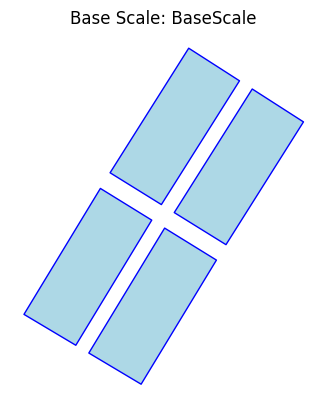

In [3]:
# Setup test environment
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Load the base spatial scale
base_scale = SpatialScale(
    name="BaseScale",
    source=SPATIAL_PATH / "base_units.shp",
    unique_id_fields="UID",
    weighting_field="Area_Ha",
    #metric_fields="NDVI",  
    measure_multiplier=None,
    type_field="HabitatTyp",
    is_base_scale=True,
    #default_crs="EPSG:4326"
)

base_scale.plot()

Loading Regions data from regions.shp...
   Requested: ['RegionID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['RegionID', 'RegionName']
   Detected geometry type: polygon (2 features)
No metric fields specified. Inferred: []
Loading Basin data from basin.shp...
   Requested: ['BasinID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['BasinID', 'BasinName']
   Detected geometry type: polygon (1 features)
No metric fields specified. Inferred: []
Plotting BaseScale with 2 aggregation scales...


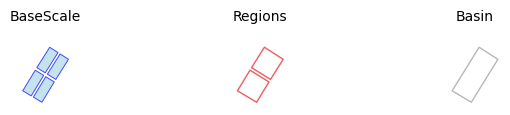

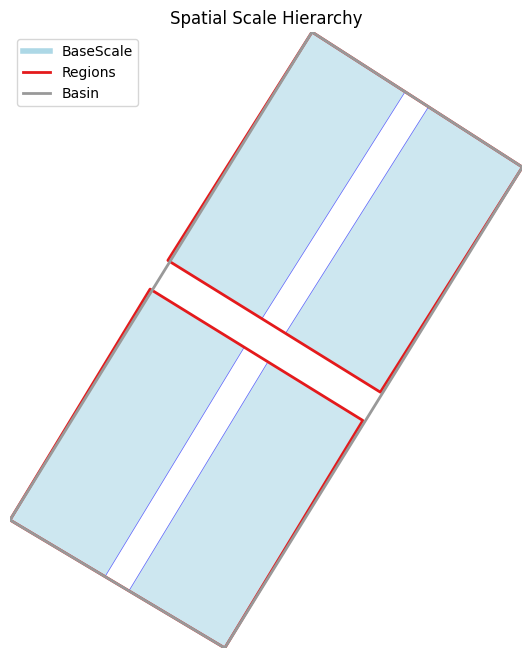

In [4]:
#create  aggregation scale objects

region_scale = SpatialScale(
    "Regions",
    source = SPATIAL_PATH / "regions.shp",
    unique_id_fields="RegionID",
)

basin_scale = SpatialScale(
    "Basin",
    source = SPATIAL_PATH / "basin.shp",
    unique_id_fields="BasinID",
)


# the first item in the list is the base scale
plot_spatial_hierarchy(base_scale, region_scale, basin_scale)

# Optional - join additional data loaded from a CSV file

Requires one column matches the base-scale `unique_id_field` so the data can be joined to the basal features.
If the data is in wide-form tabular format (wide-form) each row should be a 1:1 match with a unique_id in the base-scale data set. Unmatched rows will be dropped.
If he data is long-form it will be pivoted to wide-form and multiple columns of data will be joined to the base-scale data


join_data

Load external tabular data and join it to the SpatialScale's data.

Supports:

1. Direct join if data is in wide format (one row per unique_id).
2. Pivoting long data (key-value) into wide before join.

options:
   - data_path: Path to the CSV or tabular data file.
   - unique_id_field: Column in the CSV matching source unique ID. If None, defaults to self.unique_id.
   - pivot_row_id: If pivoting, list of columns to use as index.
   - pivot_columns: If pivoting, column name whose values become new columns.
   - pivot_values: If pivoting, column name containing values to fill.
   - how: Type of join to perform (default "inner").  Keeps only matching data and discards items with no data.




In [5]:

# Join to base scale
base_scale.join_data(
    data_path=DATA_PATH / "test_cover_data.csv",
    pivot_row_id=["UID"],
    pivot_columns="year",
    pivot_values="cover",
)


print (base_scale.data.drop(columns=['geometry']).head(10))

No metric fields specified. Inferred: ['2020', '2021', '2022']
Joined external data from test\test_cover_data.csv on '['UID']'
    UID HabitatTyp  Area_Ha  NDVI  2020  2021  2022
0  B001     Forest    200.0  0.80  0.80  0.82  0.78
1  B002    Wetland    200.0  0.60  0.60  0.58  0.62
2  B003     Forest    200.0  0.75  0.75  0.77  0.73
3  B004  Grassland    200.0  0.50  0.50  0.52  0.48


?? 4. Perform Geometry-Weighted Aggregation to Regions

In [6]:
# Geometry-weighted mean NDVI aggregated from base to regions
region_results = base_scale.aggregate_to(
    region_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="2020-2022_weighted_mean3s",
)

Performing spatial join: BaseScale to Regions using 'intersects'
⚠ Warning: Renaming 1 conflicting columns in target scale: {'Area_Ha': 'Area_Ha_target'}
Reclassifying 'HabitatTyp' into new groups 'regrouped' using substring match from reclass map...
target_scale.unique_id_fields ['RegionID']
Aggregating by ['RegionID', 'regrouped'] using 'weighted_mean'
Stored result in Regions.results['2020-2022_weighted_mean3s']


?? 4. Perform Attribute-Weighted Aggregation to Regions

In [7]:
# Geometry-weighted mean NDVI aggregated from base to regions
region_results = base_scale.aggregate_to(
    region_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    weighting_field="NDVI",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="cover_NDVI_weighted_annual_mean",
)

Using 'NDVI' for 'NDVI_weighted' aggregation
Using cached spatial join: Regions_intersects
Reclassifying 'HabitatTyp' into new groups 'regrouped' using substring match from reclass map...
target_scale.unique_id_fields ['RegionID']
Aggregating by ['RegionID', 'regrouped'] using 'weighted_mean'
Stored result in Regions.results['cover_NDVI_weighted_annual_mean']


In [8]:
region_scale.save_results("list")
print(region_scale.results["2020-2022_weighted_mean3s"])

Available results:
  2020-2022_weighted_mean3s      -          3 rows ['RegionID', 'regrouped', '2020_Areawm', '2021_Areawm', '2022_Areawm']
  cover_NDVI_weighted_annual_mean -          3 rows ['RegionID', 'regrouped', '2020_NDVIwm', '2021_NDVIwm', '2022_NDVIwm']
  RegionID   regrouped  2020_Areawm  2021_Areawm  2022_Areawm
0     R001  vegetation        0.775        0.795        0.755
1     R002  vegetation        0.500        0.520        0.480
2     R002       water        0.600        0.580        0.620


?? 5. Frequency-Weighted Aggregation to Basin

In [15]:
# Geometry-weighted mean NDVI aggregated from base to regions
basin_result= base_scale.aggregate_to(
    basin_scale,
    metric_columns=[2020, 2021, 2022],
    method="frequency_weighted",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="NDVI_frequency_weighted_mean",
)
basin_result= base_scale.aggregate_to(
    basin_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="Area_weighted_mean",
)

⚠ Warning Result 'NDVI_frequency_weighted_mean' exists. Using 'NDVI_frequency_weighted_mean_2' instead.
Using cached spatial join: Basin_intersects
Reclassifying 'HabitatTyp' into new groups 'regrouped' using substring match from reclass map...
target_scale.unique_id_fields ['BasinID']
Aggregating by ['BasinID', 'regrouped'] using 'frequency_weighted'
Stored result in Basin.results['NDVI_frequency_weighted_mean_2']
Using cached spatial join: Basin_intersects
Reclassifying 'HabitatTyp' into new groups 'regrouped' using substring match from reclass map...
target_scale.unique_id_fields ['BasinID']
Aggregating by ['BasinID', 'regrouped'] using 'weighted_mean'
Stored result in Basin.results['Area_weighted_mean']


In [10]:
basin_scale.save_results("list")

Available results:
  NDVI_frequency_weighted_mean   -          2 rows ['BasinID', 'regrouped', '2020_frqwm', '2021_frqwm', '2022_frqwm']
  cover_Area_weighted_mean       -          2 rows ['BasinID', 'regrouped', '2020_NDVIwm', '2021_NDVIwm', '2022_NDVIwm']


In [11]:
region_scale.save_results(OUTPUT_PATH, file_types=["csv", "gpkg"])

basin_scale.save_results(OUTPUT_PATH, file_types=["csv", "gpkg"])

Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Regions_2020-2022_weighted_mean3s.csv
Saved .GPKG: d:\Flow MER\mdb-scaling-up\output\Regions_2020-2022_weighted_mean3s.gpkg
Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Regions_cover_NDVI_weighted_annual_mean.csv
Saved .GPKG: d:\Flow MER\mdb-scaling-up\output\Regions_cover_NDVI_weighted_annual_mean.gpkg
Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Basin_NDVI_frequency_weighted_mean.csv
Saved .GPKG: d:\Flow MER\mdb-scaling-up\output\Basin_NDVI_frequency_weighted_mean.gpkg
Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Basin_cover_Area_weighted_mean.csv
Saved .GPKG: d:\Flow MER\mdb-scaling-up\output\Basin_cover_Area_weighted_mean.gpkg


Plotting BaseScale...
Result not found. Using BaseScale data. Saved results are dict_keys([])
Using fixed color range: [0.5, 0.8]


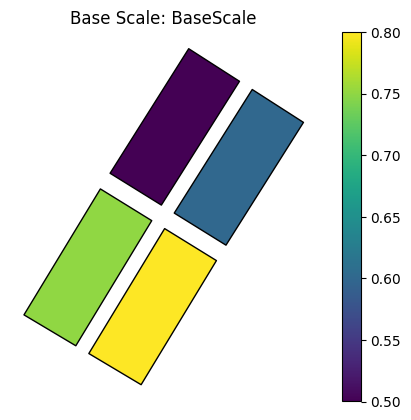

Plotting Regions...
Using fixed color range: [0.5, 0.8]


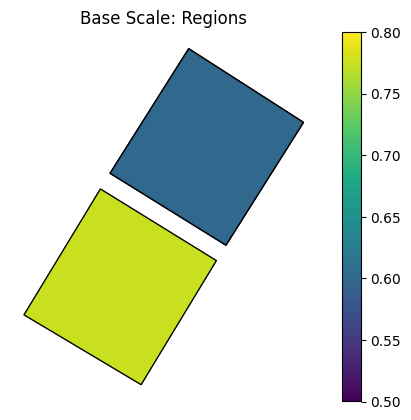

Plotting Basin...
Using fixed color range: [0.5, 0.8]


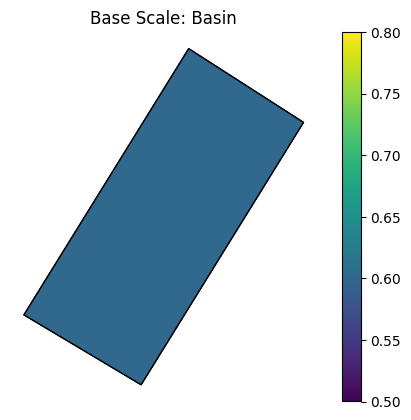

In [16]:
base_scale.plot(field="2020", color_range=[0.5, 0.8])
region_scale.plot(result ="2020-2022_weighted_mean3s", field="2020_Areawm", color_range=[0.5, 0.8])
basin_scale.plot(result="Area_weighted_mean", field="2020_Areawm", color_range=[0.5, 0.8])

In [18]:
basin_scale.results["Area_weighted_mean"].head() 

,BasinID,regrouped,2020_Areawm,2021_Areawm,2022_Areawm
0,BASIN001,vegetation,0.683333,0.703333,0.663333
1,BASIN001,water,0.600000,0.580000,0.620000
